In [1]:
## randomly loading an image into jupyter notebook and printing it.
import pandas as pd

import random
from scipy.misc import imread
%pylab inline

train = pd.read_csv('/home/aakash/Downloads/Age_Detection/train_DETg9GD/train.csv')
test = pd.read_csv('/home/aakash/Downloads/Age_Detection/test_Bh8pGW3/test.csv')
print(train.shape); print(test.shape)

import warnings
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib
(19906, 2)
(6636, 1)


/home/aakash/miniconda3/envs/datapysci/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


19132.jpg
MIDDLE


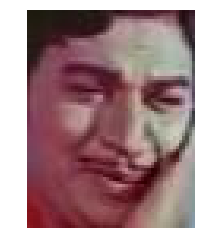

In [2]:
## Lets view some of the images.
i = random.choice(train.index)
name = train.ID[i]
print(name)
print(train.Class[i])
img = imread('/home/aakash/Downloads/Age_Detection/train_DETg9GD/Train/{}'.format(name))
pylab.imshow(img)
pylab.axis('off')
pylab.show()

In [3]:
train.Class.value_counts(normalize = True)
## So most of the actors are middle aged.
# Making our first submission
test['Class'] = 'MIDDLE'

columnsTitles=["Class","ID"]
test=test.reindex(columns=columnsTitles)
test.to_csv('sub0.csv', index = False)
print(test.head())

    Class         ID
0  MIDDLE  25321.jpg
1  MIDDLE    989.jpg
2  MIDDLE  19277.jpg
3  MIDDLE  13093.jpg
4  MIDDLE   5367.jpg


In [12]:
## Preprocessing:
## Variations in shape: One image had a shape (66, 46) whereas other had (102, 87)
# Resizing all images
from scipy.misc import imresize

temp = []
for img_name in train.ID:
    img = imread('/home/aakash/Downloads/Age_Detection/train_DETg9GD/Train/{}'.format(img_name))
    img = imresize(img, (32,32))
    img = img.astype('float32')
    temp.append(img)
train_x = np.stack(temp)

In [13]:
## Similarly for test images
temp = []
for img_name in test.ID:
    img = imread('/home/aakash/Downloads/Age_Detection/test_Bh8pGW3/Test/{}'.format(img_name))
    img = imresize(img, (32,32))
    img = img.astype('float32')
    temp.append(img)
print(temp)    
test_x = np.stack(temp)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
## Normalizing the images
train_x = train_x / 255.
test_x = test_x / 255.

train_x.shape

(19906, 32, 32, 3)

In [15]:
import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
train_y = lb.fit_transform(train.Class)
train_y = keras.utils.np_utils.to_categorical(train_y, num_classes = 3)

from sklearn.cross_validation import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.18)

In [16]:
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
## Data Augmentation.
## Generates augmented images to bring diversity to the training set and improve generalization
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# With data augmentation to prevent overfitting
datagen = image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

In [17]:
from keras.layers import LeakyReLU, BatchNormalization, Dense, Activation, Dropout, MaxPool2D
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer, Conv2D
from keras.models import Sequential

## defining our neural network architecture, adam is our optimisation algo.
## create model
model = Sequential([
    BatchNormalization(input_shape = (32, 32, 3)), Flatten(),
    Dense(units = 500, activation = 'relu'),
    Dense(output_dim = 500, input_dim = 500, activation = 'relu'),  Dropout(0.15),
    Dense(output_dim = 500, input_dim = 500, activation = 'relu'),  Dropout(0.15),
    Dense(output_dim = 500, input_dim = 500, activation = 'relu'),  Dropout(0.15),
    Dense(output_dim = 500, input_dim = 500, activation = 'relu'),  Dropout(0.15),
    Dense(output_dim = 3, input_dim = 500, activation = tf.nn.softmax)
])
#model.summary()

In [18]:
from keras.layers import AveragePooling2D

# Using a CNN Model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',activation = 'relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same',activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = tf.nn.softmax))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
__________

In [19]:
# Fit the model
# Define the optimizer
from keras.optimizers import RMSprop
adam = keras.optimizers.Adam(lr=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile the model
model.compile(optimizer = adam , loss = "categorical_crossentropy", metrics=["accuracy"])

model.fit(train_x, train_y, batch_size=256, epochs=30, verbose=1, validation_split=0.2)

Train on 15924 samples, validate on 3982 samples
Epoch 1/30
15924/15924 [==============================] - 23s 1ms/step - loss: 0.9331 - acc: 0.5521 - val_loss: 0.9015 - val_acc: 0.5814
Epoch 2/30
15924/15924 [==============================] - 21s 1ms/step - loss: 0.8384 - acc: 0.6189 - val_loss: 0.8209 - val_acc: 0.6472
Epoch 3/30
15924/15924 [==============================] - 21s 1ms/step - loss: 0.7817 - acc: 0.6523 - val_loss: 0.7665 - val_acc: 0.6735
Epoch 4/30
15924/15924 [==============================] - 21s 1ms/step - loss: 0.7548 - acc: 0.6686 - val_loss: 0.7300 - val_acc: 0.6951
Epoch 5/30
15924/15924 [==============================] - 22s 1ms/step - loss: 0.7365 - acc: 0.6712 - val_loss: 0.7351 - val_acc: 0.6959
Epoch 6/30
15924/15924 [==============================] - 22s 1ms/step - loss: 0.7165 - acc: 0.6858 - val_loss: 0.7103 - val_acc: 0.7034
Epoch 7/30
15924/15924 [==============================] - 22s 1ms/step - loss: 0.7019 - acc: 0.6883 - val_loss: 0.6914 - val_acc:

In [21]:
pred = model.predict_classes(test_x)
pred = lb.inverse_transform(pred)
## So most of the actors are middle aged.
# Making our first submission
test['Class'] = pred

columnsTitles=["Class","ID"]
test=test.reindex(columns=columnsTitles)
test.to_csv('sub0.csv', index = False)
print(test.head())

    Class         ID
0  MIDDLE  25321.jpg
1   YOUNG    989.jpg
2  MIDDLE  19277.jpg
3  MIDDLE  13093.jpg
4  MIDDLE   5367.jpg


/home/aakash/miniconda3/envs/datapysci/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
